In [1]:
# # Install some packages
# %pip install rasterio
# %pip install earthpy

In [3]:
# Imports
import tensorflow_decision_forests as tfdf
import tensorflow as tf
import pandas as pd
import numpy as np
import rasterio
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
from matplotlib.colors import from_levels_and_colors
import earthpy.plot as ep
import os

# Suppress TensorFlow INFO and WARNING messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

2024-12-10 20:33:55.141083: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733837635.157378    2036 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733837635.161898    2036 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-10 20:33:55.181082: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# Parameter
ALL_FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'EVI', 'NBR', 'NDMI', 'NDWI', 'NDBI', 'NDBaI', 'NDVI', 'elevation']
FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'EVI', 'NBR', 'NDMI', 'NDWI', 'NDBI', 'NDBaI', 'NDVI', 'elevation']
# FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'EVI', 'NBR', 'NDMI', 'NDWI', 'NDBI', 'NDBaI', 'elevation']
# FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'NDVI', 'elevation']
LABEL = ['classvalue']
CLASSES = [1, 2, 3, 4, 5, 6, 7, 8, 9]
PALETTE = ['#F08080', '#D2B48C', '#87CEFA', '#008080', '#90EE90', '#228B22', '#808000', '#006400', '#FF8C00']
SAMPLE_PATH = 'ndvi_data/Samples_LC_JambiFixedWatersAllFeatures_2023.csv'
IMAGE_PATH = 'ndvi_data/Landsat_Semarang_2023.tif'

/home/tenz/Python/py311/lib/python3.11/site-packages/earthpy/spatial.py:561: RuntimeWarning: invalid value encountered in cast
  return (bytedata.clip(low, high) + 0.5).astype("uint8")


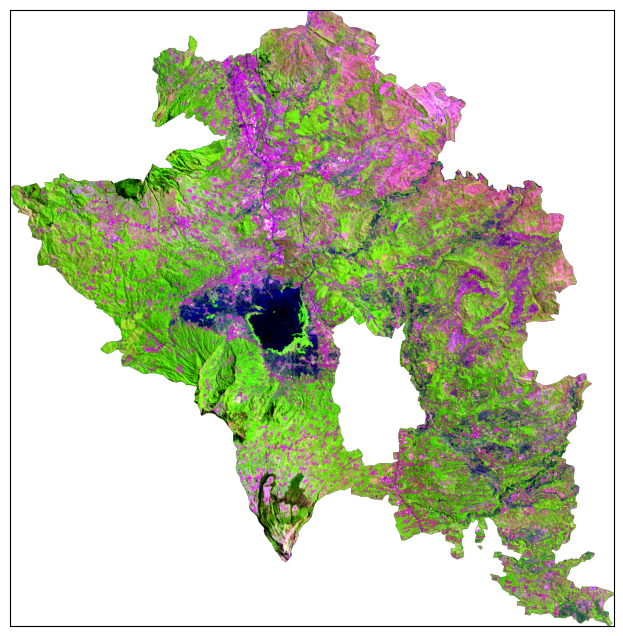

In [5]:
# Load image
image = rasterio.open(IMAGE_PATH)
height = image.height
width = image.width
shape = (height, width)

# (Optional) Visualize the image
image_vis = []
for x in [6, 5, 4]:
    image_vis.append(image.read(x))
image_vis = np.stack(image_vis)
ep.plot_rgb(image_vis, figsize=(8, 8), stretch=True)
plt.show()

In [6]:
# Read samples
samples = pd.read_csv(SAMPLE_PATH)
samples = samples.sample(frac=1)
# Ensure label is integer type
samples['classvalue'] = samples['classvalue'].astype('int32')
samples

,B1,B2,B3,B4,B5,B6,B7,EVI,NBR,NDMI,NDWI,NDBI,NDBaI,NDVI,elevation,classvalue,sample
5602,0.070270,0.085532,0.162367,0.179940,0.103133,0.034877,0.024097,-0.124584,0.621198,0.494566,0.223107,-0.494566,0.182789,-0.271335,5,3,test
1675,0.078685,0.098897,0.177850,0.237443,0.383908,0.350055,0.205817,0.177161,0.301988,0.046123,-0.366809,-0.046123,0.259479,0.235721,46,2,train
5290,0.059160,0.077970,0.153375,0.185880,0.106268,0.033337,0.018597,-0.121600,0.702118,0.522402,0.181432,-0.522402,0.283816,-0.272508,7,3,train
13226,0.022447,0.026710,0.068757,0.040212,0.401672,0.165255,0.062157,0.626394,0.731982,0.417015,-0.707682,-0.417015,0.453350,0.817996,10,7,train
13313,0.021389,0.027714,0.059572,0.039607,0.343675,0.142622,0.054650,0.553467,0.725601,0.413435,-0.704536,-0.413435,0.445944,0.793325,12,7,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4346,0.066076,0.082287,0.162381,0.201734,0.117873,0.033943,0.021870,-0.122524,0.686996,0.552844,0.158816,-0.552844,0.216305,-0.262389,5,3,train
6876,0.024042,0.031949,0.064619,0.052766,0.203040,0.091129,0.046524,0.293498,0.627159,0.380432,-0.517156,-0.380432,0.324041,0.587451,8,4,train
16745,0.015421,0.020467,0.044846,0.027150,0.309603,0.162945,0.063106,0.535355,0.661364,0.310355,-0.746952,-0.310355,0.441664,0.838754,60,8,train
8846,0.039167,0.044200,0.099035,0.082178,0.343290,0.281828,0.161652,0.433783,0.359719,0.098322,-0.552207,-0.098322,0.270982,0.613707,64,5,train


In [7]:
# Split into train and test based on 'sample' column
train = samples[samples['sample'] == 'train']
test = samples[samples['sample'] == 'test']

# Prepare data for TFDF
train_data = train[FEATURES + LABEL]
test_data = test[FEATURES + LABEL]

In [8]:
filtered_train = train[FEATURES + LABEL]
Label1 = filtered_train[filtered_train['classvalue'] == 1]
Label2 = filtered_train[filtered_train['classvalue'] == 2]
Label3 = filtered_train[filtered_train['classvalue'] == 3]
Label4 = filtered_train[filtered_train['classvalue'] == 4]
Label5 = filtered_train[filtered_train['classvalue'] == 5]
Label6 = filtered_train[filtered_train['classvalue'] == 6]
Label7 = filtered_train[filtered_train['classvalue'] == 7]
Label8 = filtered_train[filtered_train['classvalue'] == 8]
Label9 = filtered_train[filtered_train['classvalue'] == 9]

print("Label 1", Label1["classvalue"].count())
print("Label 2", Label2["classvalue"].count())
print("Label 3", Label3["classvalue"].count())
print("Label 4", Label4["classvalue"].count())
print("Label 5", Label5["classvalue"].count())
print("Label 6", Label6["classvalue"].count())
print("Label 7", Label7["classvalue"].count())
print("Label 8", Label8["classvalue"].count())
print("Label 9", Label9["classvalue"].count())

Label 1 853
Label 2 1171
Label 3 2930
Label 4 1577
Label 5 664
Label 6 3027
Label 7 2115
Label 8 2820
Label 9 2159


In [9]:
# Convert to TensorFlow datasets
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_data, label=LABEL[0])
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_data, label=LABEL[0])

I0000 00:00:1733837677.146063    2036 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1767 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [10]:
best_num_trees = 50
best_max_depth = 10
best_min_examples = 2

# Define and train the best model
rf_model = tfdf.keras.RandomForestModel(
    task=tfdf.keras.Task.CLASSIFICATION,
    num_trees=best_num_trees,
    max_depth=best_max_depth,
    min_examples=best_min_examples
)

rf_model.fit(train_ds)

# Evaluate the best model
best_evaluation = rf_model.evaluate(test_ds, return_dict=True)
print(f"Best Model Evaluation: {best_evaluation}")

Use /tmp/tmpv50chh2y as temporary training directory
Reading training dataset...
Training dataset read in 0:00:06.151656. Found 17316 examples.
Training model...


I0000 00:00:1733837683.651908    2036 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1733837683.654166    2036 kernel.cc:783] Collect training examples
I0000 00:00:1733837683.654202    2036 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1733837683.654722    2036 kernel.cc:401] Number of batches: 18
I0000 00:00:1733837683.654744    2036 kernel.cc:402] Number of examples: 17316
I0000 00:00:1733837683.656652    2036 kernel.cc:802] Training dataset:
Number of records: 17316
Number of columns: 16

Number of columns by type:
	NUMERICAL: 15 (93.75%)
	CATEGORICAL: 1 (6.25%)

Columns:

NUMERICAL: 15 (93.75%)
	0: "B1" NUMERICAL mean:0.0321

Model trained in 0:00:00.482534
Compiling model...


I0000 00:00:1733837684.122151    2036 decision_forest.cc:761] Model loaded with 50 root(s), 23126 node(s), and 15 input feature(s).
I0000 00:00:1733837684.125386    2036 abstract_model.cc:1404] Engine "RandomForestGeneric" built
2024-12-10 20:34:44.125440: I tensorflow_decision_forests/tensorflow/ops/inference/kernel.cc:1035] Use fast generic engine


Model compiled.
4/4 [==============================] - 0s 11ms/step - loss: 0.0000e+00
Best Model Evaluation: {'loss': 0.0}


In [11]:
# Evaluate the model
evaluation = rf_model.evaluate(test_ds)
print(f"Model evaluation: {evaluation}")

4/4 [==============================] - 0s 10ms/step - loss: 0.0000e+00
Model evaluation: 0.0


4/4 [==============================] - 0s 10ms/step


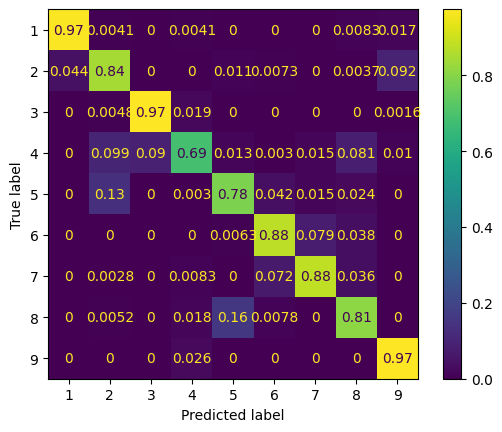

              precision    recall  f1-score   support

           1       0.95      0.97      0.96       242
           2       0.66      0.84      0.74       273
           3       0.91      0.97      0.94       626
           4       0.94      0.69      0.80       676
           5       0.77      0.78      0.78       337
           6       0.92      0.88      0.90       632
           7       0.83      0.88      0.85       361
           8       0.75      0.81      0.78       383
           9       0.80      0.97      0.88       151

    accuracy                           0.85      3681
   macro avg       0.84      0.87      0.85      3681
weighted avg       0.86      0.85      0.85      3681



In [12]:
# Predictions on test data
test_predictions = rf_model.predict(test_ds)
predicted_classes = np.argmax(test_predictions, axis=1)
true_classes = test_data[LABEL[0]].values

# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes, labels=CLASSES, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES)
disp.plot()
plt.show()

# Classification report
print(classification_report(true_classes, predicted_classes))

1138/1138 [==============================] - 12s 11ms/step


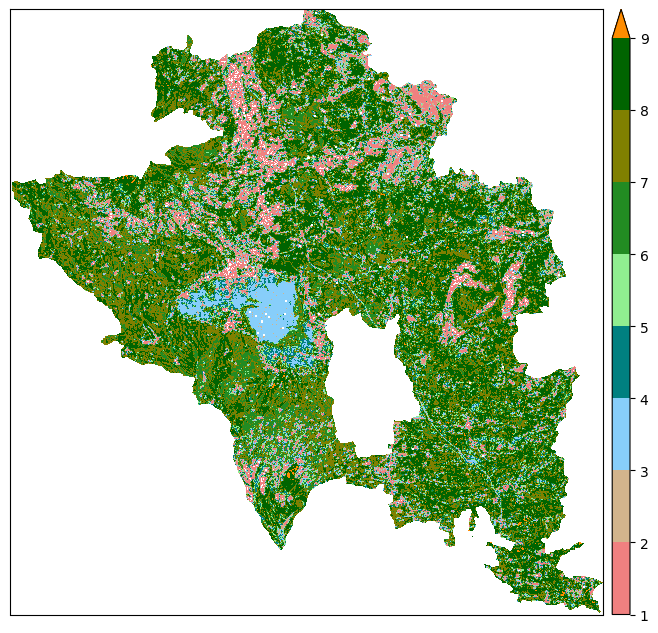

In [25]:
nodata_value = 0  # Replace with the identified value

# Read image features for prediction
image_data = []
used_image_features = [
    i + 1 for i in range(0, len(ALL_FEATURES)) if image.descriptions[i] in FEATURES
]
for i in used_image_features:
    band_data = image.read(i).flatten()
    image_data.append(band_data)

# Create DataFrame for image data
image_df = pd.DataFrame(np.array(image_data).T, columns=FEATURES)

# Automatically set invalid (no-data) pixels to NaN
image_df.replace(to_replace=[nodata_value, None], value=np.nan, inplace=True)

# Skip NaN rows during prediction
valid_pixels = ~image_df.isnull().any(axis=1)
valid_data = image_df[valid_pixels]

# Convert only valid data to TensorFlow dataset
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_data)

# Predict on valid data
valid_predictions = rf_model.predict(valid_ds)
valid_predicted_classes = np.argmax(valid_predictions, axis=1)

# Create an empty array for the output and fill in only valid predictions
image_predicted_classes = np.full(image_df.shape[0], np.nan)  # Initialize with NaN
image_predicted_classes[valid_pixels] = valid_predicted_classes

# Reshape predictions back to the original image dimensions
image_predicted_classes = image_predicted_classes.reshape((image.height, image.width))

# Visualize the predictions
cmap, norm = from_levels_and_colors(CLASSES, PALETTE, extend='max')
ep.plot_bands(image_predicted_classes, cmap=cmap, norm=norm, figsize=(8, 8))
plt.show()


In [26]:
# # Saving the Model

MODEL_SAVED_PATH = 'saved_data/'
MODEL_NAME = 'NDVI_RF_V1'

rf_model.save(MODEL_SAVED_PATH + MODEL_NAME)

# import pickle

# with open(MODEL_SAVED_PATH + MODEL_NAME + '.pkl', 'wb') as model_file:
#     pickle.dump(rf_model, model_file)